In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import torch
import networks.torch_vgg as vgg
import torch.nn as nn
import numpy as np
import math
import copy
import matplotlib.pyplot as plt

In [3]:
from main import validate
from datasets import dataprep
from gsp_model import GSP_Model
from main import AverageMeter, accuracy


In [4]:
class Args:
    arch = 'vgg19_bn'
    dataset='cifar10'
    workers = 4
    epochs=160
    start_epoch=0
    batch_size = 128
    lr = 0.1
    momentum = 0.9
    weight_decay=1e-4
    print_freq = 50
    resume = False
    evaluate = False
    pretrained = False
    half = False
    exp_name = 'gsp_test'
    
    gpu=None
    logdir = '/logdir'
    gsp_training = True 
    gsp_sps = 0.8
    scheduled_sps_run = True
    proj_filters = False
    proj_model = False
    gsp_int = 150
    gsp_start_ep = -1
    finetune = False
    finetune_sps = 0.9
    
    filelogger = None

global args, best_acc1
args = Args

In [5]:
args.resume = "/private/home/riohib/explore/gsp_cifar/cifar/model_best.pth.tar"

In [6]:
# Load Model
if args.dataset == 'cifar10': num_classes = 10
if args.dataset == 'cifar100': num_classes = 100

if 'vgg' in args.arch: model = vgg.__dict__["vgg19_bn"](num_classes=num_classes)
model = torch.nn.DataParallel(model)

model.cuda()

train_loader, val_loader = dataprep.get_data_loaders(dataset=args.dataset, args=args)

Files already downloaded and verified


In [7]:
# model_gsp = GSP_Model(model)
# model_gsp.logger = args.filelogger # Initiate Logger
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

In [8]:
# optionally resume from a checkpoint
chkpt_path = args.resume
def load_checkpoint(chkpt_path):
    checkpoint = torch.load(chkpt_path)
    args.start_epoch = checkpoint['epoch'] if not args.finetune else 0
    best_acc1 = checkpoint['best_acc1'] if not args.finetune else 0
    model.load_state_dict(checkpoint['state_dict'])

load_checkpoint(chkpt_path)


In [9]:
fft_model = copy.deepcopy(model)

In [11]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 93.090 



93.09

In [12]:
validate(val_loader, fft_model, criterion, args)


 Validation Acc@1: 93.090 



93.09

### Transforms

In [13]:
params_d = dict()
names = list()
for name, params in model.named_parameters():
    names.append(name)
    params_d[name] = params

In [14]:
param_fft = torch.fft.fftn(params_d[names[4]])

In [14]:
module_d = dict()
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module_d[name] = module.weight.data

In [15]:
weight_tensor = module_d[name].flatten()
numelem = weight_tensor.shape[0]
topk_weights = numelem * 0.1
print(topk_weights)

512.0


In [16]:
module_d[name].shape

torch.Size([10, 512])

In [15]:
def threshold_tensor(in_tensor, sparsity=0.9):
    t_shape = in_tensor.shape
    tensor = in_tensor.flatten()
    w_sps_num =  len(tensor) * sparsity
    sorted_weights, _ = torch.sort(tensor.abs())
    threshold = sorted_weights[:math.ceil(w_sps_num)+1][-1]
    sps_tensor = torch.where(abs(tensor) < threshold, torch.tensor(0.0, device=tensor.device), tensor)
    out_tensor = sps_tensor.reshape(t_shape)
    return out_tensor

def get_mask(in_tensor, sparsity=0.9):
    out_tensor = threshold_tensor(in_tensor, sparsity=sparsity)
    mask = out_tensor > 0.0   
    return mask 

In [ ]:
# if transform_func.__name__ == 'fft_fft':
#     inverse_trans = torch.fft.ifft
# elif transform_func.__name__ == 'fft_fftn':
#     inverse_trans = torch.fft.ifftn
#     print("using ifft")

In [85]:
# def model_fft_ifft(model):
fft_module = dict()
ifft_module = dict()
sps_fft = dict()
sps_abs_fft = dict()
sps = 0.6

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        fft_module[name] = torch.fft.fft(module.weight.data) # apply FFT
        sps_abs_fft[name] = torch.abs(fft_module[name]) # get absolute FFT vales (make real)
        sps_mask = get_mask(sps_abs_fft[name], sparsity=sps) # use the normalized real values for getting the topk mask
        sps_fft_tensor = fft_module[name] * sps_mask # but mask the actual complex FFT values topk
        ifft_module[name] = torch.fft.ifft(sps_fft_tensor).real # IFFT the sparse complex topk and save only the real values


In [91]:
def populate_fft_model(ifft_modules):
    for name, module in fft_model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            module.weight.data = ifft_module[name]
    return fft_model

In [92]:
# def model_fft_ifft(model):
def transform_threshold(model, sps, transform_func):
    fft_model = copy.deepcopy(model)
    fft_module = dict()
    ifft_module = dict()
    sps_abs_fft = dict()

    if transform_func.__name__ == 'fft_fft':
        inverse_trans = torch.fft.ifft
    elif transform_func.__name__ == 'fft_fftn':
        inverse_trans = torch.fft.ifftn
        print("using ifft")

    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            fft_module[name] = transform_func(module.weight.data) # apply FFT
            sps_abs_fft[name] = torch.abs(fft_module[name]) # get absolute FFT vales (make real)
            sps_mask = get_mask(sps_abs_fft[name], sparsity=sps) # use the normalized real values for getting the topk mask
            sps_fft_tensor = fft_module[name] * sps_mask # but mask the actual complex FFT values topk
            ifft_module[name] = inverse_trans(sps_fft_tensor).real # IFFT the sparse complex topk and save only the real values
    return ifft_module, fft_model

In [112]:
ifft_modules = transform_threshold(model, 0.5, torch.fft.fft)
fft_model = populate_fft_model(ifft_modules)
validate(val_loader, fft_model, criterion, args)


 Validation Acc@1: 68.180 



68.18

In [108]:
sps_list = np.linspace(0.1, 0.95, 5)
sps_list = list(sps_list)
sps_list

[0.1, 0.3125, 0.525, 0.7374999999999999, 0.95]

In [111]:
acc_list = list()
for sps in sps_list:
    print(sps)
    ifft_modules = transform_threshold(model, sps, torch.fft.fft)
    fft_model = populate_fft_model(ifft_modules)
    acc1 = validate(val_loader, fft_model, criterion, args)
    acc_list.append(acc1)

0.1

 Validation Acc@1: 68.180 

0.3125

 Validation Acc@1: 68.180 

0.525

 Validation Acc@1: 68.180 

0.7374999999999999

 Validation Acc@1: 68.180 

0.95

 Validation Acc@1: 68.180 



In [107]:
print(sps_list)
for sps in sps_list:
    print(sps)

# acc_list

[]


In [94]:
acc1 = validate(val_loader, fft_model, criterion, args)
print(acc1)


 Validation Acc@1: 68.180 

68.18


In [57]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 93.090 



93.09

In [ ]:
sps_list = []

### Model Step Class

In [6]:
if 'vgg' in args.arch: model = vgg.__dict__["vgg19_bn"](num_classes=10)
model = torch.nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [7]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
train_loader, val_loader = dataprep.get_data_loaders(dataset=args.dataset, args=args)

Files already downloaded and verified


In [32]:
optimizer.param_groups[0]['lr']

0.1

In [25]:
dir(optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_hook_for_profile',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [8]:
from analysis import ModelAnalysis

In [9]:
exp = ModelAnalysis(model, optimizer, criterion, train_loader, val_loader)

In [22]:
exp.validate()


 Validation Acc@1: 30.000 



30.0

In [11]:
exp.train_mode()

Setting to train mode


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


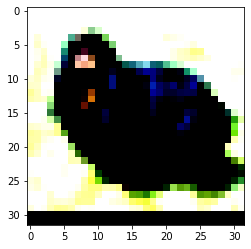

In [33]:
data, label = exp.sample_data()
image = data[0].cpu()
plt.imshow(image.permute(1, 2, 0))

In [21]:
stepz =380 * 3
for i in range(stepz):
    loss = exp.sample_forward()
    exp.backward(loss)
    exp.step()

In [12]:
for i in range(760):
    loss = exp.iterate_once()
    print(f"[{i}] loss: {loss}")

[0] loss: 2.3201189041137695
[1] loss: 2.339859962463379
[2] loss: 2.283064365386963
[3] loss: 2.9042866230010986
[4] loss: 2.7028861045837402
[5] loss: 2.7130579948425293
[6] loss: 3.2010178565979004
[7] loss: 3.5326085090637207
[8] loss: 3.358269691467285
[9] loss: 3.0857889652252197
[10] loss: 4.496649265289307
[11] loss: 4.309123516082764
[12] loss: 4.221973419189453
[13] loss: 4.295749664306641
[14] loss: 4.054405689239502
[15] loss: 5.4131598472595215
[16] loss: 3.7319021224975586
[17] loss: 4.064109802246094
[18] loss: 4.120781421661377
[19] loss: 4.344333648681641
[20] loss: 4.747957706451416
[21] loss: 3.5490329265594482
[22] loss: 4.2142653465271
[23] loss: 3.621762275695801
[24] loss: 3.128854513168335
[25] loss: 3.1459438800811768
[26] loss: 3.3066670894622803
[27] loss: 4.193065166473389
[28] loss: 3.7613747119903564
[29] loss: 5.176436901092529
[30] loss: 4.407149791717529
[31] loss: 4.196115493774414
[32] loss: 5.588255405426025
[33] loss: 3.328944683074951
[34] loss: 6.

In [35]:
for i in range(5):
    exp.train_epoch()

Training: batch_id:[0] | Acc@1: 26.56 | Loss: 1.938923954963684
Training: batch_id:[20] | Acc@1: 21.54 | Loss: 2.0795178413391113
Training: batch_id:[40] | Acc@1: 21.49 | Loss: 2.0643038749694824
Training: batch_id:[60] | Acc@1: 21.54 | Loss: 1.9637987613677979
Training: batch_id:[80] | Acc@1: 21.65 | Loss: 2.0018930435180664
Training: batch_id:[100] | Acc@1: 22.06 | Loss: 1.9809231758117676
Training: batch_id:[120] | Acc@1: 22.31 | Loss: 2.1040079593658447
Training: batch_id:[140] | Acc@1: 22.41 | Loss: 2.0015015602111816
Training: batch_id:[160] | Acc@1: 22.67 | Loss: 1.907214641571045
Training: batch_id:[180] | Acc@1: 22.78 | Loss: 1.997668981552124
Training: batch_id:[200] | Acc@1: 22.97 | Loss: 1.9010010957717896
Training: batch_id:[220] | Acc@1: 23.14 | Loss: 1.9728494882583618
Training: batch_id:[240] | Acc@1: 23.18 | Loss: 1.971200942993164
Training: batch_id:[260] | Acc@1: 23.34 | Loss: 2.035740852355957
Training: batch_id:[280] | Acc@1: 23.55 | Loss: 1.8482301235198975
Traini

In [333]:
loss = exp.sample_forward()
print(loss)
exp.backward(loss)
exp.step()

tensor(3.5723, device='cuda:0', grad_fn=<NllLossBackward0>)


TypeError: backward() missing 1 required positional argument: 'loss'

In [310]:
for i in range(100):
    exp.iterate_once()

Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to

In [320]:
params_d = dict()
for name, params in exp.model.named_parameters():
    params_d[name] = params

In [321]:
params_d

{'module.features.0.weight': Parameter containing:
 tensor([[[[ 0.1759, -0.0015,  0.0382],
           [-0.0113,  0.0736, -0.0569],
           [ 0.0417,  0.0545, -0.0611]],
 
          [[-0.0418, -0.0942, -0.0136],
           [ 0.1758, -0.0062,  0.0290],
           [ 0.0151,  0.0022,  0.0441]],
 
          [[ 0.0153, -0.0438,  0.0523],
           [ 0.0268, -0.0200,  0.0332],
           [ 0.0451,  0.0590, -0.0263]]],
 
 
         [[[ 0.0064, -0.0202,  0.0373],
           [-0.0789, -0.1407,  0.0120],
           [ 0.0401,  0.0815,  0.0572]],
 
          [[ 0.1374,  0.0087, -0.0596],
           [ 0.0080, -0.0809, -0.2124],
           [-0.0584,  0.0580, -0.0757]],
 
          [[-0.1096, -0.0294,  0.0258],
           [ 0.0101, -0.0099,  0.0276],
           [-0.0332,  0.0481,  0.0646]]],
 
 
         [[[ 0.0080,  0.0292,  0.0222],
           [-0.0299, -0.0185, -0.1320],
           [ 0.0155,  0.0494,  0.0325]],
 
          [[ 0.0109, -0.0619, -0.0642],
           [-0.0409,  0.0621, -0.0045],
  

In [288]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 29.608 



29.608386075949365

In [244]:
for i, (input, target) in enumerate(train_loader):
    target = target.cuda()
    input_var = input.cuda()
    target_var = target

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output = output.float()
    loss = loss.float()
    # measure accuracy and record loss
    prec1 = accuracy(output.data, target)[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))